# ICT4SM lab 3 - group 14

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv("Unipol_dataset_lab3.csv")

## Preliminary Analysis

In [19]:
df

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00
...,...,...,...,...,...,...,...
1415300,1415300,1000,474,2023-11-28 13:15:02,2023-11-28 13:36:51,U,0.52
1415301,1415301,1000,475,2023-11-28 14:49:22,2023-11-28 15:09:03,U,0.00
1415302,1415302,1000,476,2023-11-28 15:16:18,2023-11-28 15:18:11,U,0.00
1415303,1415303,1000,477,2023-11-28 15:18:31,2023-11-28 15:28:41,U,0.00


### Distribution of trip distance of different types of roads

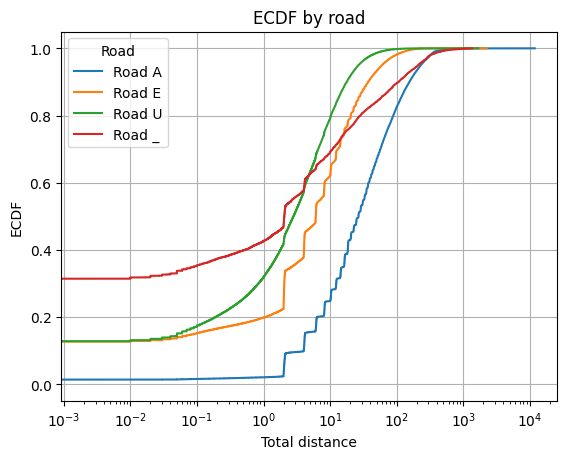

In [42]:
for road, group in df.groupby('road'):
    
    x = np.sort(group['total_distance'])
    y = np.arange(1, len(x) + 1) / len(x) # Calculate cumulated probabilities 
    
    plt.step(x, y, label=f'Road {road}')

plt.xscale('log')
plt.xlabel('Total distance')
plt.ylabel('ECDF')
plt.title('ECDF by road')
plt.legend(title='Road')
plt.grid()
plt.show()

- Road A : Highwaw
- Road E : Extra-Urban
- Road U : Urban

Highway trips rise slower than Urban or extraurban trips showing that user taking the highway tend to go further with their car, indicating longer trips, as could be expected with the use of highways. The fastest rise of Urban ECDF compared to Extra-Urban is also coherent with a use within a smaller zone (the city) with shorter distances.

### Distribution of trip duration

C:\Users\sartr\AppData\Local\Temp\ipykernel_8012\3483215745.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_durations = df.groupby('trip_id').apply(


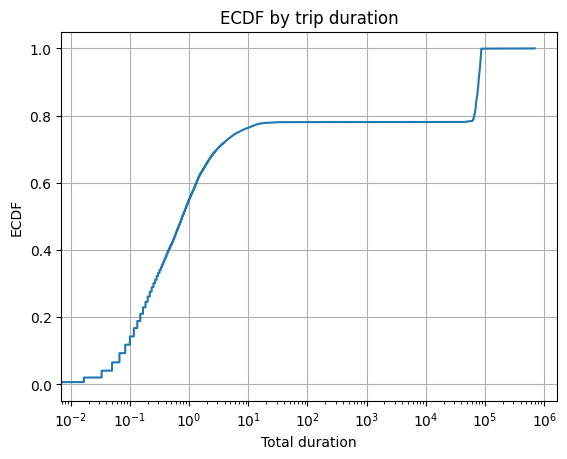

In [53]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])

trip_durations = df.groupby('trip_id').apply(
    lambda group: (group['stop_time'].max() - group['start_time'].min()).total_seconds() / 60
).reset_index(name='durations')

x = np.sort(trip_durations['durations'])
y = np.arange(1, len(x) + 1) / len(x)

plt.plot(x,y)
plt.xscale('log')
plt.xlabel('Total duration')
plt.ylabel('ECDF')
plt.title('ECDF by trip duration')
plt.grid()
plt.show()

Some surprisingly high values, even though 80% are below 100s trip (around one and a half hour) we see some anormally long trips, up to 10**5 seconds which is a visible outlier. There also are some too short trips.

### Relationship between trip duration and distance

There is indeed a relationship between trip duration and distance : speed. Speed = distance/duration. For a same trip on different roads, we should see different speed. 

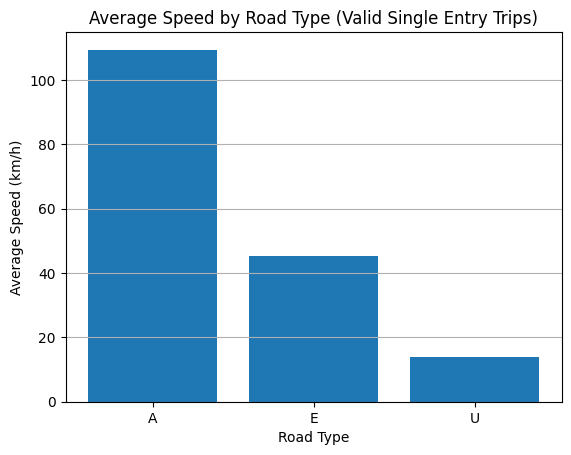

In [144]:
# Eliminate trips that have various roads
once_trips = df.groupby('trip_id').filter(lambda group: len(group) == 1)

once_trips['start_time'] = pd.to_datetime(once_trips['start_time'])
once_trips['stop_time'] = pd.to_datetime(once_trips['stop_time'])

once_trips['duration_hours'] = (once_trips['stop_time'] - once_trips['start_time']).dt.total_seconds() / 3600 # Duration of the trip

once_trips['speed_kmh'] = once_trips['total_distance'] / once_trips['duration_hours'] # Calculate the speed of the trip

valid_trips = once_trips[once_trips['duration_hours'] >= 0.02] # Eliminating too short trips (that give too high speed)

average_speed_by_road = valid_trips.groupby('road')['speed_kmh'].mean().reset_index() # Calculating the average speed


plt.bar(average_speed_by_road['road'], average_speed_by_road['speed_kmh'])

plt.xlabel('Road Type')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed by Road Type (Valid Single Entry Trips)')
plt.grid(axis='y')
plt.show()



We eliminated the too short trips (duration < 0.02 sec) because they gave too high speeds and incorrect representation and the trips that had been made on different roads, since the speed would change but we have only the global time of the trip. We therefore see that we indeed have a higher speed on highways than in extra urban that itself has greater speed than urban. The speed values are even relatively coherent with known speed in these roads, maybe a bit too fast on highway and too slow elsewhere.

### How many valid trips are recorded in the dataset?

We can delete trips that are : 
- Below and over IQR durations 
- Require a speed more than one and a half over the average speed on their road (unfeasible trips)
- Below and over IQR distances
- Occured on an unknown road

In [3]:
def filter_data(df):
    df = pd.read_csv("Unipol_dataset_lab3.csv")
    old = df.shape[0]
    print(f"Initial total number of trips: {old}")

    # Duration in hours and speed
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['stop_time'] = pd.to_datetime(df['stop_time'])
    df['duration_hours'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 3600
    df['speed'] = df['total_distance'] / df['duration_hours']

    # Group by road and calculate the average speed
    road_speed = df.groupby('road')['speed'].mean().reset_index(name='average_speed')

    # Merge the average speed back into the original DataFrame
    df = pd.merge(df, road_speed, on='road', how='left')

    # Filter 1: Remove trips with speed > 1.5 * average road speed
    df = df[df['speed'] <= 1.5 * df['average_speed']]

    # Filter 2: Remove trips with total distance < 1 km
    df = df[df['total_distance'] >= 1]

    # Filter 3: Remove unknown roads (not 'A', 'E', or 'U')
    df = df[df['road'].isin(['A', 'E', 'U'])]

    # Filter 4: Remove extreme values in distance and duration (outside IQR)
    # Compute IQR for total_distance
    q1_distance = df['total_distance'].quantile(0.25)
    q3_distance = df['total_distance'].quantile(0.75)
    iqr_distance = q3_distance - q1_distance
    lower_bound_distance = q1_distance - 1.5 * iqr_distance
    upper_bound_distance = q3_distance + 1.5 * iqr_distance

    # Compute IQR for duration_hours
    q1_duration = df['duration_hours'].quantile(0.25)
    q3_duration = df['duration_hours'].quantile(0.75)
    iqr_duration = q3_duration - q1_duration
    lower_bound_duration = q1_duration - 1.5 * iqr_duration
    upper_bound_duration = q3_duration + 1.5 * iqr_duration

    # Apply IQR filters
    df = df[
        (df['total_distance'] >= lower_bound_distance) & 
        (df['total_distance'] <= upper_bound_distance) & 
        (df['duration_hours'] >= lower_bound_duration) & 
        (df['duration_hours'] <= upper_bound_duration)
    ]

    # Debug: Final dataset shape
    new = df.shape[0]
    percentage = (old - new) / old * 100
    print(f"Total number of valid trips: {new}")
    print(f"Percentage of trips removed: {percentage:.2f}%")

    return df

# Apply the filter
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df)


Initial total number of trips: 1415305
Total number of valid trips: 899767
Percentage of trips removed: 36.43%


# Tasks

## 1. Analysing behaviours of vehicles

### Compute the statistics and distribution of the values on workdays and weekends/holidays.

Initial total number of trips: 1415305
Total number of valid trips: 899767
Percentage of trips removed: 36.43%


C:\Users\sartr\AppData\Local\Temp\ipykernel_18068\972121328.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


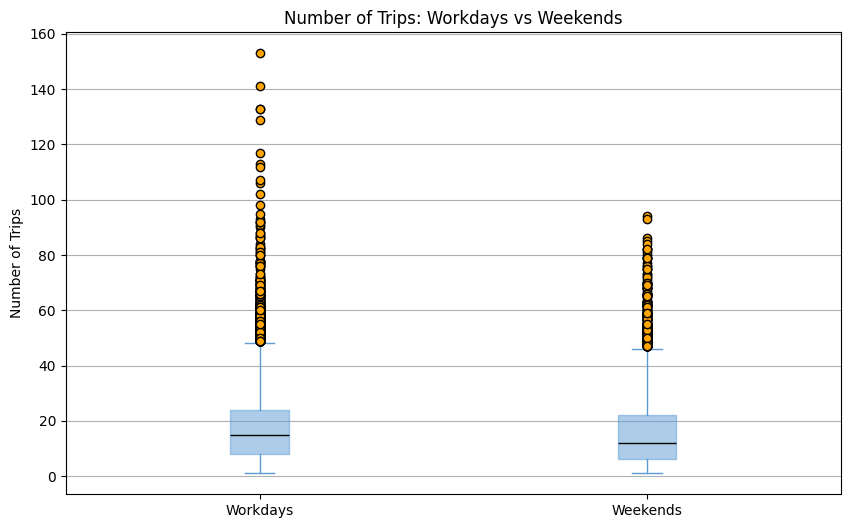

C:\Users\sartr\AppData\Local\Temp\ipykernel_18068\972121328.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


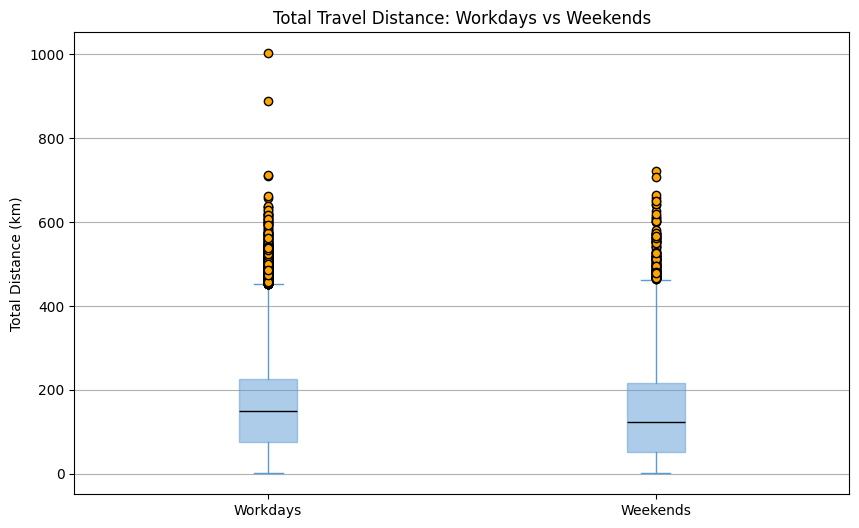

C:\Users\sartr\AppData\Local\Temp\ipykernel_18068\972121328.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


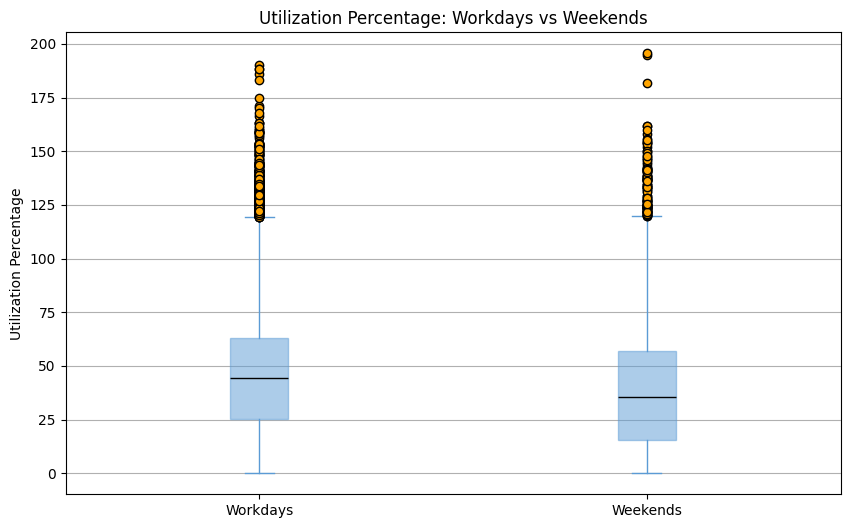

In [34]:
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df) 

# Convert start_time and stop_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])
df['day'] = df['start_time'].dt.date # Get the good date format to detect if it is a weekend or not later
df['driving_time_minutes'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 60

# Aggregate daily stats per vehicle
daily_stats = df.groupby(['vehicle_id', 'day']).agg(
    num_trips=('trip_id', 'count'),
    total_distance=('total_distance', 'sum'),
    total_driving_time=('driving_time_minutes', 'sum')
).reset_index()

daily_stats['utilization_percentage'] = (daily_stats['total_driving_time'] / (24 * 60)) * 100 # Calculate utilization percentage

# Classify workdays (0-4) and weekends (5-6)
daily_stats['day_of_week'] = pd.to_datetime(daily_stats['day']).dt.weekday
daily_stats['is_weekend'] = daily_stats['day_of_week'].isin([5, 6])

# Prepare data for boxplots
workday_trips = daily_stats[daily_stats['is_weekend'] == False]['num_trips']
weekend_trips = daily_stats[daily_stats['is_weekend'] == True]['num_trips']

workday_distance = daily_stats[daily_stats['is_weekend'] == False]['total_distance']
weekend_distance = daily_stats[daily_stats['is_weekend'] == True]['total_distance']

workday_utilization = daily_stats[daily_stats['is_weekend'] == False]['utilization_percentage']
weekend_utilization = daily_stats[daily_stats['is_weekend'] == True]['utilization_percentage']

# Function to plot a boxplot
def plot_boxplot(data, labels, title, ylabel, colors):
    plt.figure(figsize=(10, 6))
    plt.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        boxprops=dict(facecolor=colors[0], color=colors[0], alpha=0.5),
        medianprops=dict(color='black'),
        whiskerprops=dict(color=colors[0]),
        capprops=dict(color=colors[0]),
        flierprops=dict(marker='o', markerfacecolor=colors[1], markersize=6, linestyle='none')
    )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.show()

# Number of Trips
plot_boxplot(
    data=[workday_trips, weekend_trips],
    labels=['Workdays', 'Weekends'],
    title='Number of Trips: Workdays vs Weekends',
    ylabel='Number of Trips',
    colors=['#5B9BD5', 'orange']
)

# Total Travel Distance
plot_boxplot(
    data=[workday_distance, weekend_distance],
    labels=['Workdays', 'Weekends'],
    title='Total Travel Distance: Workdays vs Weekends',
    ylabel='Total Distance (km)',
    colors=['#5B9BD5', 'orange']
)

# Utilization Percentage
plot_boxplot(
    data=[workday_utilization, weekend_utilization],
    labels=['Workdays', 'Weekends'],
    title='Utilization Percentage: Workdays vs Weekends',
    ylabel='Utilization Percentage',
    colors=['#5B9BD5', 'orange']
)


generally the same patterns between the week with lower usage, distance and trips on weekends compared with workdays, which is also normal because there are 5 workdays instead of 2 days of the weekend, so this difference is most likely not relevant. Nevertheless, the difference is relevant for the the percentage of utilization since this statistic is daily-based, therefore eliminating this mecanical growing effect due to a higher number of days to agregate.

### 1.b : For each vehicle, compute the fraction of its trips with different road types

Initial total number of trips: 1415305
Total number of valid trips: 899767
Percentage of trips removed: 36.43%


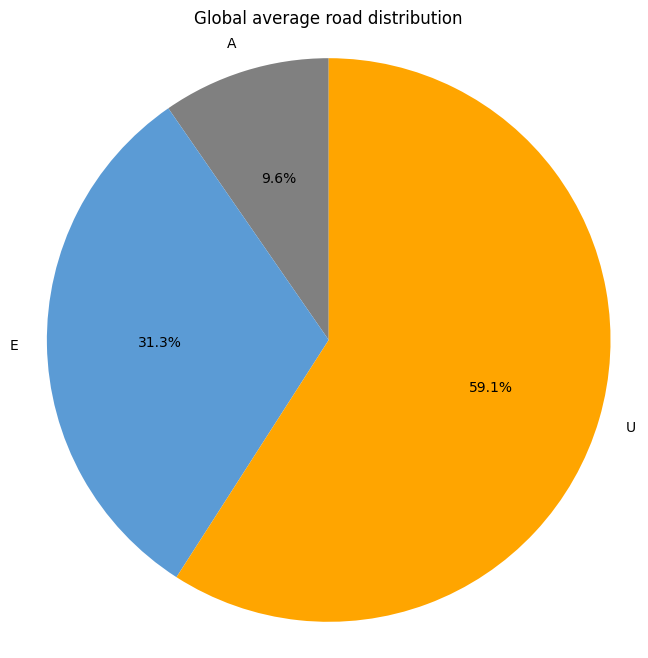

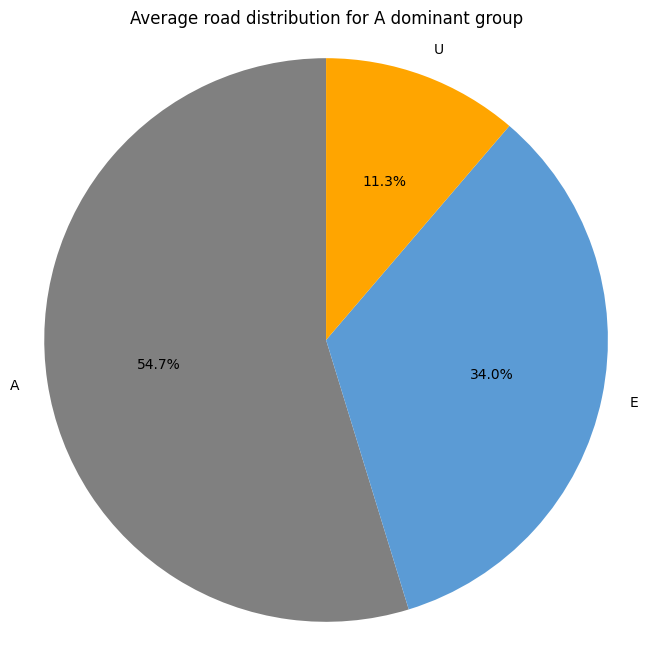

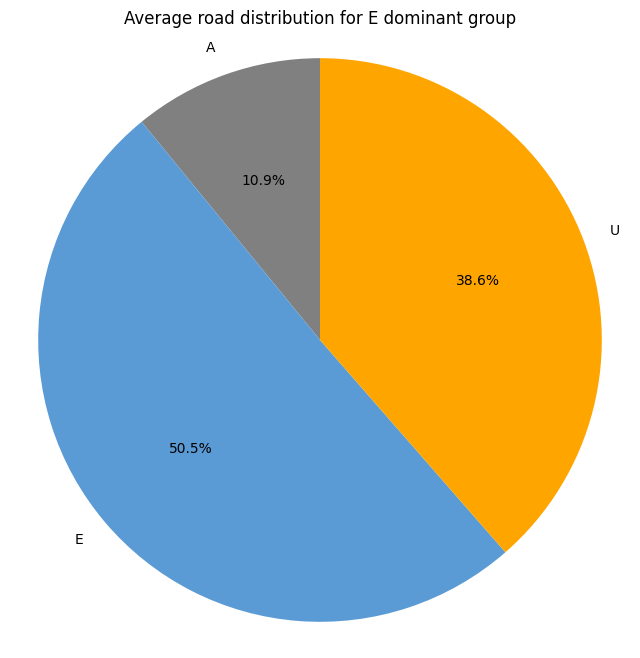

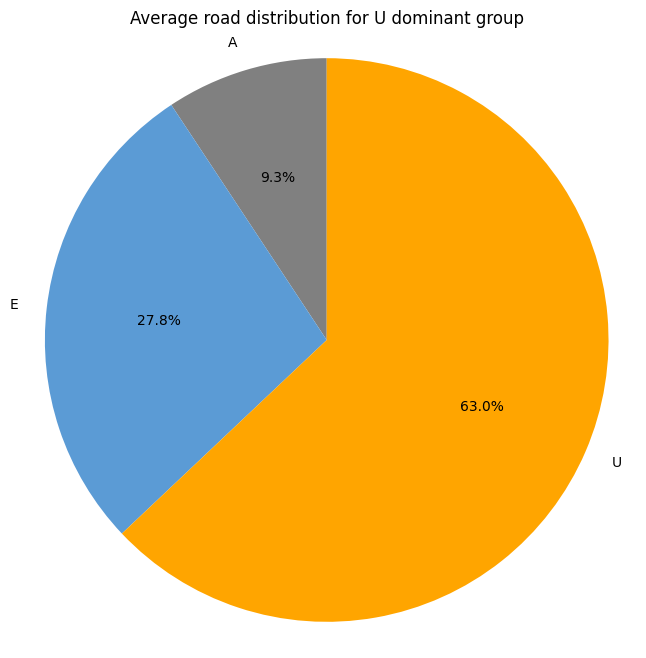

In [32]:
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df)

# Calculate the number of trips by road for each vehicle and fraction
road_counts = df.groupby(['vehicle_id', 'road'])['trip_id'].count().reset_index(name='road_trip_count')
total_trips = road_counts.groupby('vehicle_id')['road_trip_count'].sum().reset_index(name='total_trips')

road_fractions = pd.merge(road_counts, total_trips, on='vehicle_id')
road_fractions['road_fraction'] = road_fractions['road_trip_count'] / road_fractions['total_trips']

# Pivot to get road fractions for each vehicle
road_fraction_pivot = road_fractions.pivot(index='vehicle_id', columns='road', values='road_fraction').fillna(0)

# Calculate global average road distribution
global_averages = road_fraction_pivot.mean()

# Plot global average road distribution
plt.figure(figsize=(8, 8))
labels = global_averages.index
sizes = global_averages.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors= ['grey','#5B9BD5','orange'])
plt.title('Global average road distribution')
plt.axis('equal')
plt.show()

# Plot average road distribution for each dominant group
road_fraction_pivot['dominant_road'] = road_fraction_pivot.idxmax(axis=1)  # Identify dominant road by vehicle (most represented one)
dominant_groups = road_fraction_pivot.groupby('dominant_road')  # Group vehicles by their dominant road
group_averages = dominant_groups.mean()  # Average fractions per road type for each group

for road, avg_fraction in group_averages.iterrows():
    plt.figure(figsize=(8, 8))
    labels = avg_fraction.index
    sizes = avg_fraction.values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors= ['grey','#5B9BD5','orange'])
    plt.title(f'Average road distribution for {road} dominant group')
    plt.axis('equal')
    plt.show()

We chose here to represent the average fraction repartition of roads for cars separated in three groups, defined by the road that is the most represented, A for highway, E or U. We can see that in general, user stick for a very large part to the road they use most and do not show a very balances usage of roads, unless they use mainly highways. This shows that highway users tend to have an equilibrated mobility diagram and may moove mor throu different situations whereas extra urban and mostly urban users keep more the same usage.

### 1.C Clustering

Initial total number of trips: 1415305
Total number of valid trips: 899767
Percentage of trips removed: 36.43%


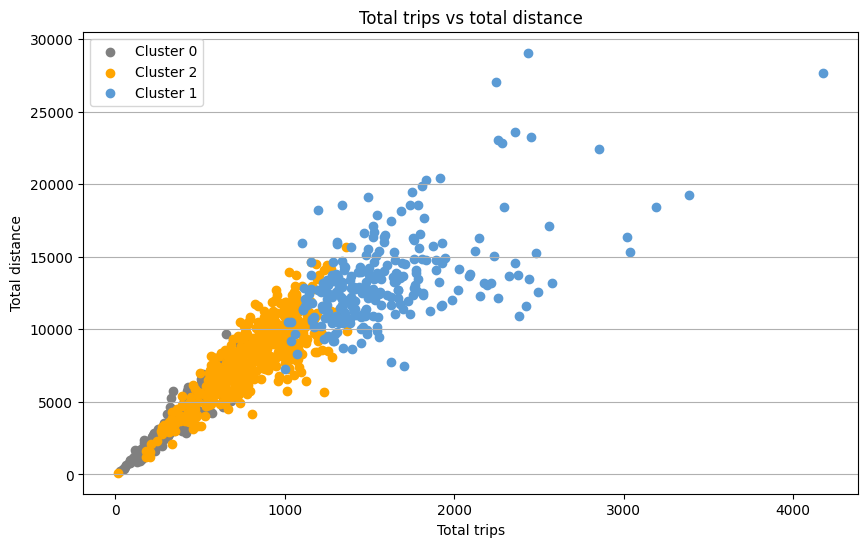

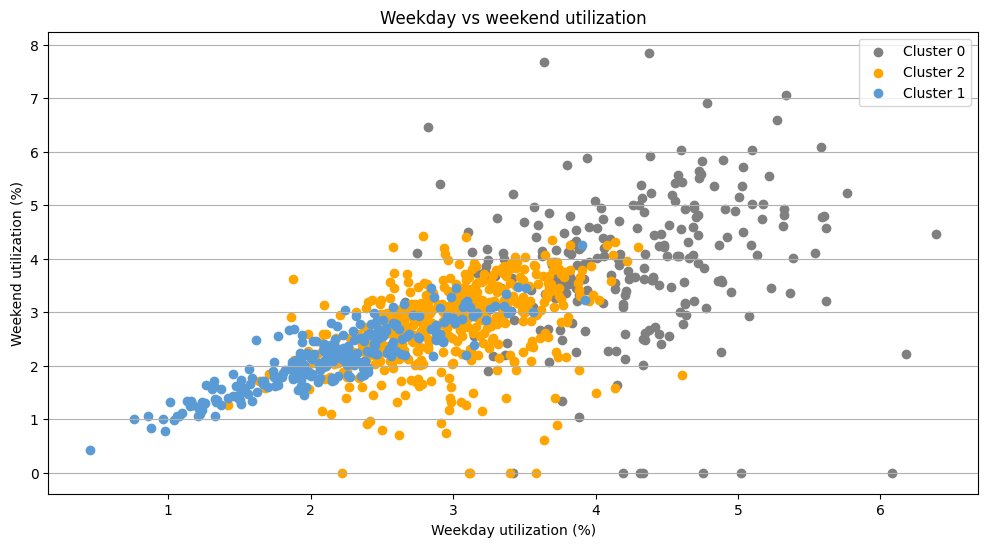

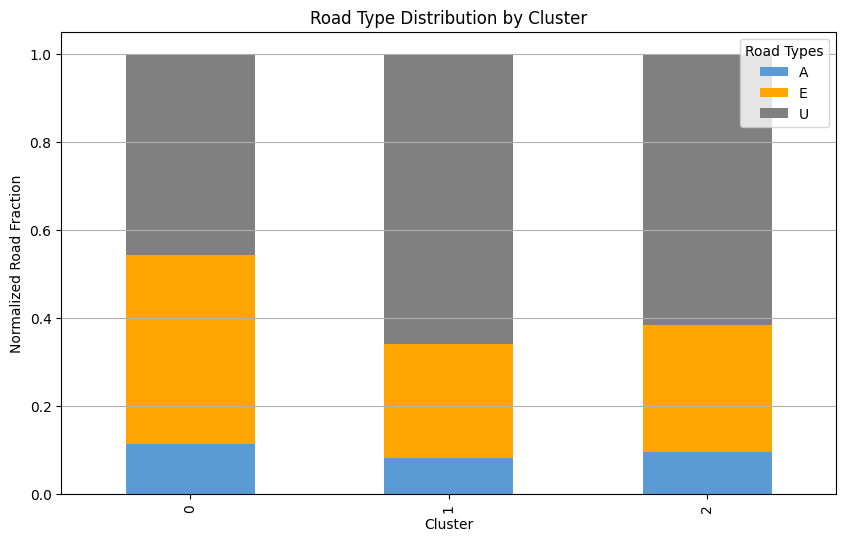

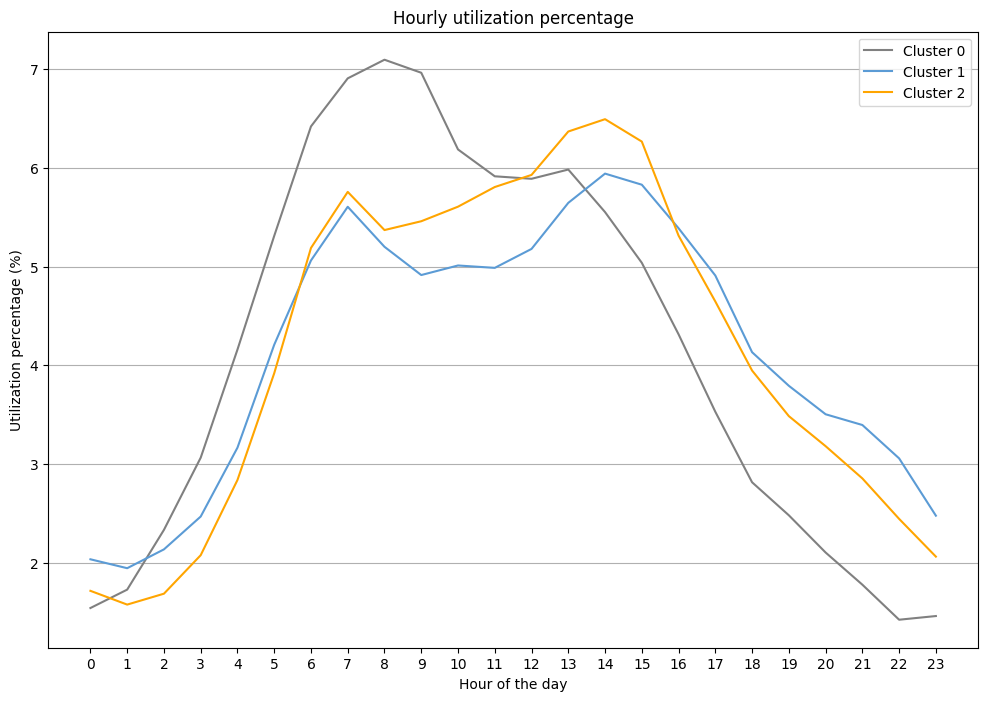

In [98]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df['start_time'] = pd.to_datetime(df['start_time'])
df['stop_time'] = pd.to_datetime(df['stop_time'])
df['duration_hours'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 3600



def compute_workday_weekend_stats(df): # Same code as before
    df['is_weekend'] = df['start_time'].dt.weekday >= 5  
    stats = df.groupby(['vehicle_id', 'is_weekend']).agg(
        num_trips=('trip_id', 'count'),
        total_distance=('total_distance', 'sum'),
        utilization_percentage=('duration_hours', lambda x: x.sum() / (24 * len(x)) * 100)
    ).unstack(fill_value=0)
    
    stats.columns = [f"{stat}_{'weekend' if weekend else 'workday'}" for stat, weekend in stats.columns]
    return stats.reset_index()


def compute_road_type_fractions(df): #Same code as before 
    road_counts = df.groupby(['vehicle_id', 'road'])['trip_id'].count().reset_index(name='road_trip_count')
    total_trips = road_counts.groupby('vehicle_id')['road_trip_count'].sum().reset_index(name='total_trips')
    road_fractions = road_counts.merge(total_trips, on='vehicle_id')
    road_fractions['road_fraction'] = road_fractions['road_trip_count'] / road_fractions['total_trips']
    
    road_fraction_pivot = road_fractions.pivot(index='vehicle_id', columns='road', values='road_fraction').fillna(0)
    return road_fraction_pivot.reset_index()


# Add the calculated data into the dataframe
def enrich_vehicle_data(df):
    workday_stats = compute_workday_weekend_stats(df)
    road_type_fractions = compute_road_type_fractions(df)

    vehicle_stats = df.groupby('vehicle_id').agg(
        total_trips=('trip_id', 'count'),
        total_distance=('total_distance', 'sum'),
        avg_trip_duration=('duration_hours', 'mean'),
        utilization_percentage=('duration_hours', lambda x: x.sum() / (24 * len(x)) * 100)
    ).reset_index()

    enriched_data = vehicle_stats.merge(workday_stats, on='vehicle_id', how='left')
    enriched_data = enriched_data.merge(road_type_fractions, on='vehicle_id', how='left')
    return enriched_data.fillna(0)


# Do the clustering
def perform_clustering(vehicle_data, n_clusters=3):
    features = vehicle_data.drop(columns=['vehicle_id']).fillna(0)
    normalized_features = StandardScaler().fit_transform(features)
    vehicle_data['cluster'] = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(normalized_features)
    return vehicle_data


# Functions to plot clusters with specified colors
cluster_colors = ['grey', '#5B9BD5', 'orange']

def plot_clusters(vehicle_data):
    plt.figure(figsize=(10, 6))
    for cluster in vehicle_data['cluster'].unique():
        cluster_data = vehicle_data[vehicle_data['cluster'] == cluster]
        plt.scatter(cluster_data['total_trips'], 
                    cluster_data['total_distance'], 
                    label=f'Cluster {cluster}', 
                    color=cluster_colors[cluster])  
    plt.xlabel('Total trips')
    plt.ylabel('Total distance')
    plt.title('Total trips vs total distance')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Function to plot road type fractions with specified colors
def plot_road_type_fractions(vehicle_data):
    road_columns = ['A', 'E', 'U']
    road_fractions = vehicle_data.groupby('cluster')[road_columns].mean()

    road_fractions = road_fractions.div(road_fractions.sum(axis=1), axis=0)

    # Plot stacked bar chart this time so that it is more clear to see the comparison
    ax = road_fractions.plot(kind='bar', stacked=True, color=['#5B9BD5', 'orange', 'grey'], figsize=(10, 6))  
    plt.xlabel('Cluster')
    plt.ylabel('Normalized Road Fraction')
    plt.title('Road Type Distribution by Cluster')
    plt.legend(title='Road Types')
    plt.grid(axis='y')
    plt.show()

# Function to plot weekday vs weekend utilization with specified colors
def plot_weekday_weekend(vehicle_data):
    plt.figure(figsize=(12, 6))
    for cluster in vehicle_data['cluster'].unique():
        cluster_data = vehicle_data[vehicle_data['cluster'] == cluster]
        plt.scatter(cluster_data['utilization_percentage_workday'], 
                    cluster_data['utilization_percentage_weekend'], 
                    label=f'Cluster {cluster}', 
                    color=cluster_colors[cluster])  
    plt.xlabel('Weekday utilization (%)')
    plt.ylabel('Weekend utilization (%)')
    plt.title('Weekday vs weekend utilization')
    plt.legend()
    plt.grid(axis='y')
    plt.show()

# Function to plot hourly utilization with specified colors
def plot_hourly_utilization(df, vehicle_data):
    df = pd.merge(df, vehicle_data[['vehicle_id', 'cluster']], on='vehicle_id', how='left')
    df['hour'] = df['start_time'].dt.hour
    df['duration_hours'] = (df['stop_time'] - df['start_time']).dt.total_seconds() / 3600
    hourly_utilization = df.groupby(['cluster', 'hour'])['duration_hours'].sum().reset_index()
    hourly_utilization['normalized_utilization'] = hourly_utilization.groupby('cluster')['duration_hours'].transform(lambda x: x / x.sum())
    plt.figure(figsize=(12, 8))
    for cluster in hourly_utilization['cluster'].unique():
        cluster_data = hourly_utilization[hourly_utilization['cluster'] == cluster]
        plt.plot(
            cluster_data['hour'],
            cluster_data['normalized_utilization'] * 100,
            label=f'Cluster {cluster}',
            color=cluster_colors[cluster]  
        )

    plt.title('Hourly utilization percentage')
    plt.xlabel('Hour of the day')
    plt.ylabel('Utilization percentage (%)')
    plt.xticks(range(24), range(24))
    plt.grid(axis='y')
    plt.legend()
    plt.show()

# Main Workflow
df = pd.read_csv("Unipol_dataset_lab3.csv")
df = filter_data(df)  
vehicle_data = enrich_vehicle_data(df)
clustered_data = perform_clustering(vehicle_data)

# Plot Results with Custom Colors
plot_clusters(clustered_data)
plot_weekday_weekend(clustered_data)
plot_road_type_fractions(clustered_data)
plot_hourly_utilization(df, clustered_data)



AFter testing three diferent numbers of clusters, it seems that the most representative number of cluster is 3. We found :

- Cluster 0 with (Light users) :  
    - Mostly Urban (U) trips.
    - Active during classic working hours (morning and evening).
    - Could represent personal or low-usage vehicles.
    - Cluster 1 (Moderate/Regular Users):

- Cluster 1 (Moderate users) : 
    - Moderate trips and distance with mixed road type usage.
    - Same utilization for the day and week.
    - Likely vehicles used for mixed purposes like suburban delivery or work/personal transport.

- Cluster 2 (Heavy users) :
    - High total trips and distance, witha lot of highways (A) and extra urban areas (E).
    - High utilization on weekdays, especially during early hours.
    - Likely profesionnal-use vehicles, such as logistics or inter-city transport.

## 2. Choose and define the evaluation metrics that you want to monitor

We chose the following three EV models to evaluate : 
- BMW i4 eDrive40 (light users) https://ev-database.org/car/1252/BMW-i4-eDrive40
- Skoda Elroq 85 (moderate users) https://ev-database.org/car/3033/Skoda-Elroq-85
- Audi Q6 e-tron Sportback quattro (heavy users) https://ev-database.org/car/3043/Audi-Q6-e-tron-Sportback-quattro

The metrics that we are going to track will be : 
- Percentage of feasible trips
- Percentage of completedness of the trip
- Battery percentage at the end of the day

## 3. Implement the replicator of trips and simulator of EV

C:\Users\sartr\AppData\Local\Temp\ipykernel_18068\2410379673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data['start_time'] = pd.to_datetime(vehicle_data['start_time'])
C:\Users\sartr\AppData\Local\Temp\ipykernel_18068\2410379673.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data['stop_time'] = pd.to_datetime(vehicle_data['stop_time'])


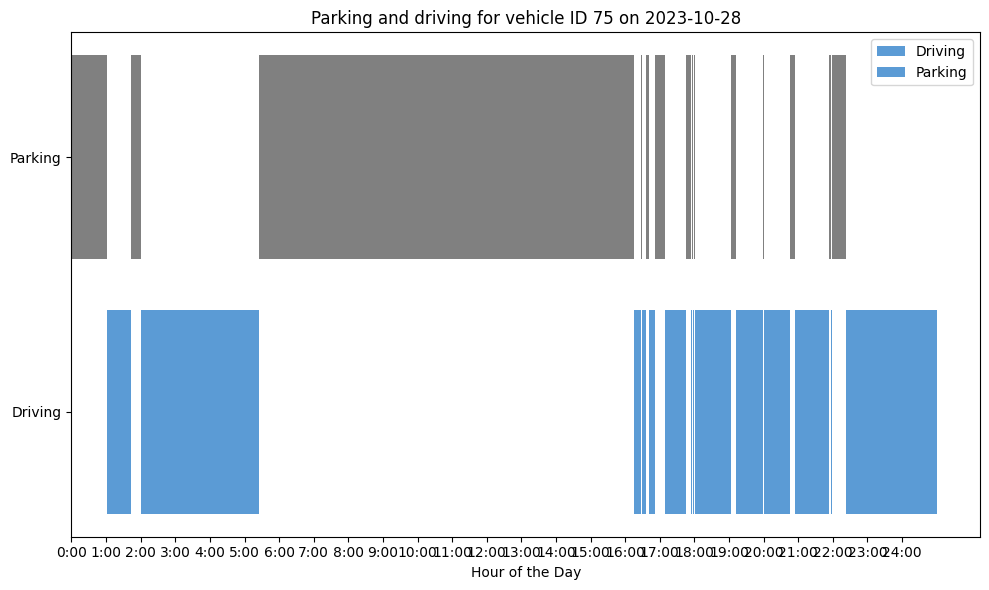

In [36]:
df = pd.read_csv('Unipol_dataset_lab3.csv')

random_vehicle_id = df['vehicle_id'].sample(1).iloc[0] # Select a random vehicle for the moment

# Filter the dataset for the selected vehicle
vehicle_data = df[df['vehicle_id'] == random_vehicle_id]

# Convert start and stop times to datetime format
vehicle_data['start_time'] = pd.to_datetime(vehicle_data['start_time'])
vehicle_data['stop_time'] = pd.to_datetime(vehicle_data['stop_time'])

random_day = vehicle_data['start_time'].dt.date.sample(1).iloc[0] # Select a random day for the moment
vehicle_data = vehicle_data[vehicle_data['start_time'].dt.date == random_day]

# Define the start and end of the day
start_of_day = pd.Timestamp(f"{random_day} 00:00:00")
end_of_day = pd.Timestamp(f"{random_day} 23:59:59")

# Calculate parking intervals
parking_intervals = []
sorted_data = vehicle_data.sort_values('start_time')
current_time = start_of_day

for _, row in sorted_data.iterrows():
    if row['start_time'] > current_time:
        parking_intervals.append((current_time, row['start_time']))
    current_time = row['stop_time']
if current_time < end_of_day:
    parking_intervals.append((current_time, end_of_day))

plt.figure(figsize=(10, 6))

for _, row in vehicle_data.iterrows():
    plt.barh('Driving', (row['stop_time'] - row['start_time']).total_seconds() / 3600, left=(row['start_time'] - start_of_day).total_seconds() / 3600, color='#5B9BD5')

for start, stop in parking_intervals:
    plt.barh('Parking', (stop - start).total_seconds() / 3600, left=(start - start_of_day).total_seconds() / 3600, color='grey')

plt.xlabel('Hour of the Day')
plt.xticks(range(0, 25), labels=[f"{h}:00" for h in range(0, 25)])
plt.title(f'Parking and driving for vehicle ID {random_vehicle_id} on {random_day}')
plt.legend(['Driving', 'Parking'], loc='upper right')
plt.tight_layout()
plt.show()


For the moment here to visualise and get a first idea of the simulation, we take a random vehicle on a random day and vizualise its usage. We here have implemented the idea of the parking slots too, so that we will be able to complete the EV simulation for the next steps. We see in this example that many of the parking times may not be enough to effectifvzly charge the car.

For simplicity reasons, we consider all the charging rates as a fast charging configuration, assuming that the vehicle would get charged during the day at professional charging stations.
- battery_capacity : Useable Capacity
- consumption : real consumptions depending on the road, with a mild weather
- charging power : we took the 10-80% value for fast charging

In [88]:
car_models = {
    "BMW i4 eDrive40": {
        "highway": {"battery_capacity": 807000, "consumption": 166, "fast": 131000, "slow": 11000},
        "city": {"battery_capacity": 807000, "consumption": 109, "fast": 131000, "slow": 11000},
        "combined": {"battery_capacity": 807000, "consumption": 136, "fast": 131000, "slow": 11000}
    },
    "Skoda Elroq 85": {
        "highway": {"battery_capacity": 77000, "consumption": 220, "fast": 120000, "slow": 11000},
        "city": {"battery_capacity": 77000, "consumption": 190, "fast": 120000, "slow": 11000},
        "combined": {"battery_capacity": 77000, "consumption": 200, "fast": 120000, "slow": 11000}
    },
    "Audi Q6 e-tron Sportback quattro": {
        "highway": {"battery_capacity": 949000, "consumption": 460, "fast": 200000, "slow": 11000},
        "city": {"battery_capacity": 949000, "consumption": 715, "fast": 200000, "slow": 11000},
        "combined": {"battery_capacity": 949000, "consumption": 570, "fast": 200000, "slow": 11000}
    }
}

# Map road types to categories
road_mapping = {
    'A': 'highway',
    'E': 'combined',
    'U': 'city',
    '-': 'combined'
}

def analyze_vehicle(vehicle_id, dataset, car_models, road_mapping):
    # Filtrer les données pour le véhicule spécifique
    vehicle_data = dataset[dataset['vehicle_id'] == vehicle_id].sort_values('start_time')

    results = []

    for car_model, specs in car_models.items():
        for charging_policy in ["fast", "slow"]:
            # Charger les résultats pour cette politique
            charging_power_key = charging_policy

            # Initialiser les variables
            battery_capacity = None
            consumption = None
            battery_remaining = None
            feasible_trips = 0
            completedness_sum = 0
            total_trips = 0

            for _, trip in vehicle_data.iterrows():
                # Trouver le type de route correspondant
                trip_road_type = road_mapping.get(trip['road'].strip(), 'combined')
                if trip_road_type not in specs:
                    continue

                # Charger les spécifications de la voiture
                road_specs = specs[trip_road_type]
                battery_capacity = road_specs["battery_capacity"]
                consumption = road_specs["consumption"]
                charging_power = road_specs[charging_power_key]

                # Initialiser la batterie au début de la journée
                if battery_remaining is None:
                    battery_remaining = battery_capacity

                # Calculer l'énergie nécessaire pour le trajet
                required_energy = trip['total_distance'] * consumption

                # Vérifier si le trajet est faisable
                if required_energy <= battery_remaining:
                    feasible_trips += 1
                    battery_remaining -= required_energy
                else:
                    battery_remaining = 0  # Arrive à destination avec 0 SoC

                # Calculer le niveau de complétion
                completedness = min((battery_remaining / required_energy) * 100, 100) if required_energy > 0 else 0
                completedness_sum += completedness

                total_trips += 1

                # Gérer la recharge pendant le stationnement
                if total_trips < len(vehicle_data):  # Si un prochain trajet existe
                    next_trip_start = vehicle_data.iloc[total_trips]['start_time']
                    parking_duration = (next_trip_start - trip['stop_time']).total_seconds() / 60  # en minutes

                    if parking_duration > 20:  # Recharge uniquement si stationnement > 20 minutes
                        charging_time = parking_duration - 20
                        charging_energy = charging_time * charging_power / 60  # Convertir minutes en heures
                        battery_remaining = min(battery_remaining + charging_energy, battery_capacity)

            # Calculer les métriques finales
            percentage_feasible = (feasible_trips / total_trips) * 100 if total_trips > 0 else 0
            average_completedness = completedness_sum / total_trips if total_trips > 0 else 0
            end_of_day_battery = (battery_remaining / battery_capacity) * 100 if battery_remaining is not None else 0

            # Ajouter les résultats
            results.append({
                "car_model": car_model,
                "charging_policy": charging_policy,
                "percentage_feasible": percentage_feasible,
                "average_completedness": average_completedness,
                "end_of_day_battery": end_of_day_battery
            })

    return pd.DataFrame(results)


# Example usage for a single vehicle
# Load the dataset
dataset = pd.read_csv('Unipol_dataset_lab3.csv')
dataset['start_time'] = pd.to_datetime(dataset['start_time'])
dataset['stop_time'] = pd.to_datetime(dataset['stop_time'])

vehicle_id = dataset['vehicle_id'].sample(1).iloc[0]

# Analyze for both home and fast charging policies
results = analyze_vehicle(vehicle_id, dataset, car_models, road_mapping)

# Combine results and ensure 6-line summary for display
final_summary = results.groupby(["car_model", "charging_policy"], as_index=False).agg({
    "percentage_feasible": "mean",
    "average_completedness": "mean",
    "end_of_day_battery": "mean"
}).sort_values(by=["car_model", "charging_policy"], ascending=[True, True])

print(f"Results Summary for Vehicle ID {vehicle_id}")
print(final_summary)


Results Summary for Vehicle ID 459
                          car_model charging_policy  percentage_feasible  \
0  Audi Q6 e-tron Sportback quattro            fast           100.000000   
1  Audi Q6 e-tron Sportback quattro            slow            98.723724   
2                   BMW i4 eDrive40            fast           100.000000   
3                   BMW i4 eDrive40            slow           100.000000   
4                    Skoda Elroq 85            fast            98.348348   
5                    Skoda Elroq 85            slow            91.291291   

   average_completedness  end_of_day_battery  
0              90.090090           87.952034  
1              88.676092            1.813154  
2              90.090090           96.978887  
3              90.090090           96.978887  
4              87.933300           52.209487  
5              80.428105           52.209487  


### 4. Conduct the simulation of all the vehicles

Unfeasible trips by car model and charging policy:
      vehicle_id                         car_model charging_policy  \
0              1                   BMW i4 eDrive40            fast   
1              1                   BMW i4 eDrive40            slow   
2              1                    Skoda Elroq 85            fast   
3              1                    Skoda Elroq 85            slow   
4              1  Audi Q6 e-tron Sportback quattro            fast   
...          ...                               ...             ...   
5995        1000                   BMW i4 eDrive40            slow   
5996        1000                    Skoda Elroq 85            fast   
5997        1000                    Skoda Elroq 85            slow   
5998        1000  Audi Q6 e-tron Sportback quattro            fast   
5999        1000  Audi Q6 e-tron Sportback quattro            slow   

      unfeasible_trips  
0                    0  
1                    0  
2                  126  
3       

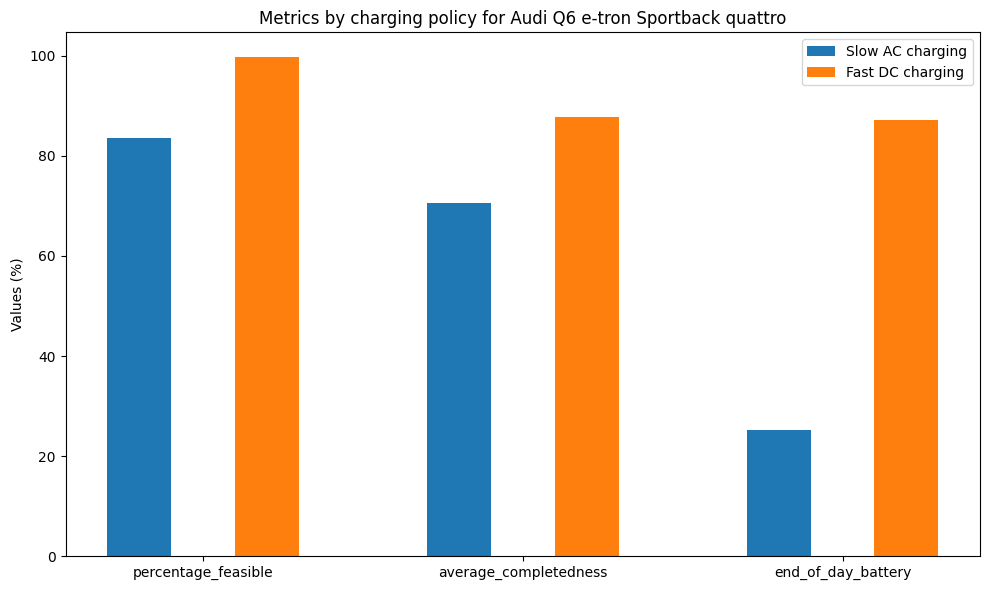

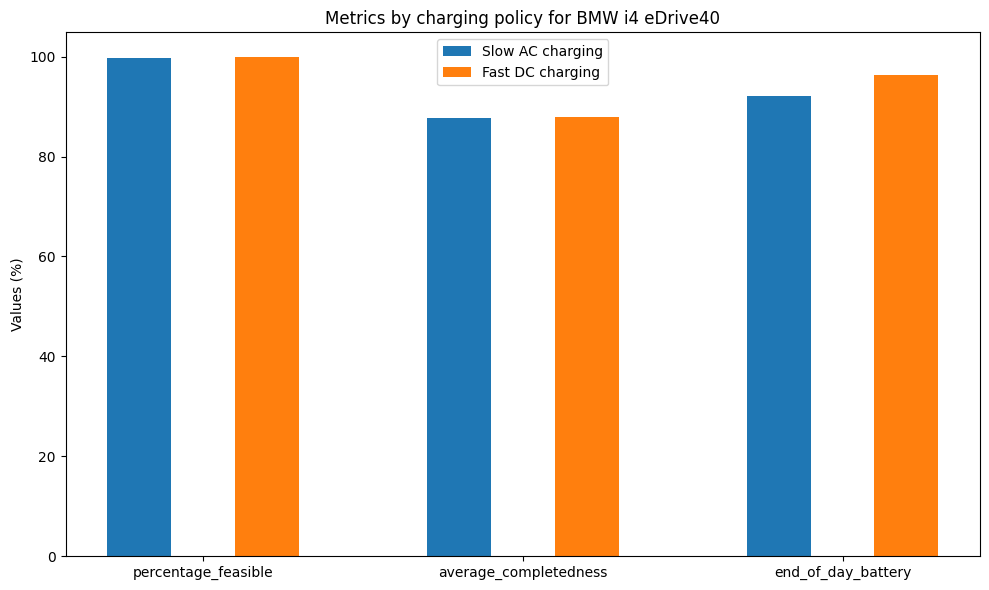

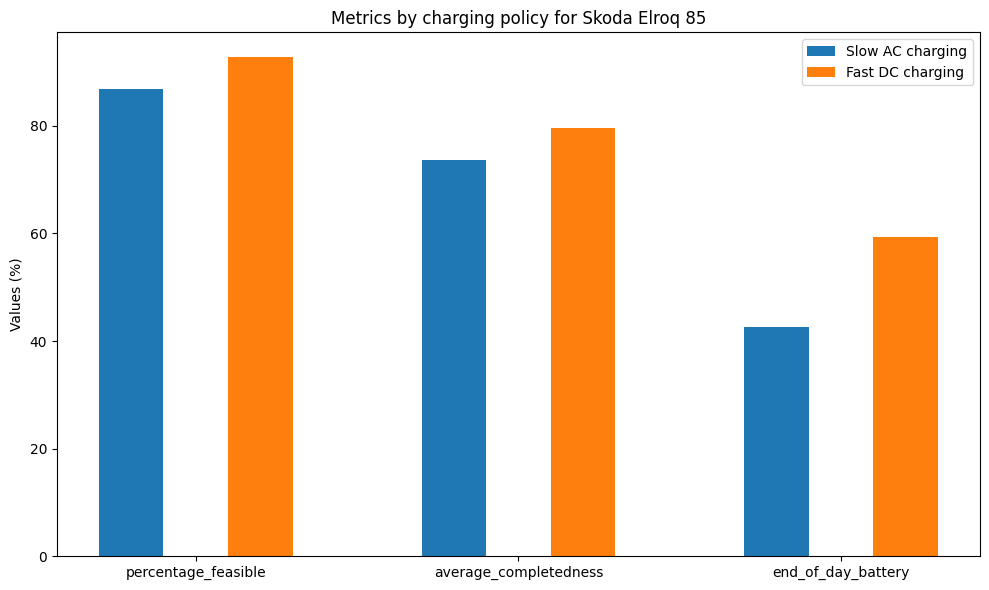

In [96]:
dataset = pd.read_csv('Unipol_dataset_lab3.csv')
dataset['start_time'] = pd.to_datetime(dataset['start_time'])
dataset['stop_time'] = pd.to_datetime(dataset['stop_time'])

# Get unique vehicle IDs
unique_vehicle_ids = dataset['vehicle_id'].unique()

# Initialize a list to store results
all_results = []
unfeasible_trip_details = []

# Loop through all vehicles
for vehicle_id in unique_vehicle_ids:
    # Analyze the vehicle and append the results
    results = analyze_vehicle(vehicle_id, dataset, car_models, road_mapping)
    all_results.append(results)

    # Count unfeasible trips for this vehicle
    vehicle_data = dataset[dataset['vehicle_id'] == vehicle_id].sort_values('start_time')
    for car_model, specs in car_models.items():
        for charging_policy in ["fast", "slow"]:
            unfeasible_trips = 0
            battery_remaining = None

            for _, trip in vehicle_data.iterrows():
                # Map road type
                trip_road_type = road_mapping.get(trip['road'].strip(), 'combined')
                if trip_road_type not in specs:
                    continue

                # Load specs for the road type and charging policy
                road_specs = specs[trip_road_type]
                consumption = road_specs["consumption"]
                battery_capacity = road_specs["battery_capacity"]
                charging_power = road_specs[charging_policy]  # Use the correct charging policy

                # Initialize battery at the start of the day
                if battery_remaining is None:
                    battery_remaining = battery_capacity

                # Calculate energy required for the trip
                required_energy = trip['total_distance'] * consumption

                # Check feasibility
                if required_energy > battery_remaining:
                    unfeasible_trips += 1
                    battery_remaining = 0  # Assume the vehicle arrives with 0 SoC
                else:
                    battery_remaining -= required_energy

                # Simulate charging during stops (only applies for intermediate trips)
                if trip.name < len(vehicle_data) - 1:
                    next_trip_start = vehicle_data.iloc[trip.name + 1]['start_time']
                    parking_duration = (next_trip_start - trip['stop_time']).total_seconds() / 60
                    if parking_duration > 20:  # Recharge if parked for more than 20 minutes
                        charging_time = parking_duration - 20
                        charging_energy = (charging_time / 60) * charging_power
                        battery_remaining = min(battery_remaining + charging_energy, battery_capacity)

            unfeasible_trip_details.append({
                "vehicle_id": vehicle_id,
                "car_model": car_model,
                "charging_policy": charging_policy,
                "unfeasible_trips": unfeasible_trips
            })


combined_results = pd.concat(all_results, ignore_index=True) # Combine results into a single DataFrame

# Group results by car model and charging policy for summary
final_summary = combined_results.groupby(["car_model", "charging_policy"], as_index=False).agg({
    "percentage_feasible": "mean",
    "average_completedness": "mean",
    "end_of_day_battery": "mean"
})

unfeasible_trip_df = pd.DataFrame(unfeasible_trip_details) # Previous code a little redundant but easier like this

# Create histograms for each car model
car_models_in_results = final_summary['car_model'].unique()

for car_model in car_models_in_results:
    car_model_data = final_summary[final_summary['car_model'] == car_model] # Filter data for the current car model

    # Plot metrics with slow on one side and fast on the other
    x = ["slow", "fast"]
    metrics = ["percentage_feasible", "average_completedness", "end_of_day_battery"]

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    positions = [i - bar_width for i in range(len(metrics))]  # Left positions (slow)
    values_slow = car_model_data[car_model_data['charging_policy'] == 'slow'][metrics].values.flatten()
    ax.bar(positions, values_slow, bar_width, label='Slow AC charging')
    positions = [i + bar_width for i in range(len(metrics))]  # Right positions (fast)
    values_fast = car_model_data[car_model_data['charging_policy'] == 'fast'][metrics].values.flatten()
    ax.bar(positions, values_fast, bar_width, label='Fast DC charging')

    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics)
    ax.set_title(f'Metrics by charging policy for {car_model}')
    ax.set_ylabel('Values (%)')
    ax.legend()
    plt.tight_layout()
    plt.show()


### 4.a Report and comment how many trips are unfeasible

In [95]:

for vehicle_id in unique_vehicle_ids:
    # Analyze the vehicle and append the results
    results = analyze_vehicle(vehicle_id, dataset, car_models, road_mapping)
    all_results.append(results)

    # Count unfeasible trips for this vehicle
    vehicle_data = dataset[dataset['vehicle_id'] == vehicle_id].sort_values('start_time')
    for car_model, specs in car_models.items():
        for charging_policy in ["fast", "slow"]:
            unfeasible_trips = 0
            battery_remaining = None

            for _, trip in vehicle_data.iterrows():
                # Map road type
                trip_road_type = road_mapping.get(trip['road'].strip(), 'combined')
                if trip_road_type not in specs:
                    continue

                # Load specs for the road type and charging policy
                road_specs = specs[trip_road_type]
                consumption = road_specs["consumption"]
                battery_capacity = road_specs["battery_capacity"]
                charging_power = road_specs[charging_policy]  # Use the correct charging policy

                # Initialize battery at the start of the day
                if battery_remaining is None:
                    battery_remaining = battery_capacity

                # Calculate energy required for the trip
                required_energy = trip['total_distance'] * consumption

                # Check feasibility
                if required_energy > battery_remaining:
                    unfeasible_trips += 1
                    battery_remaining = 0  # Assume the vehicle arrives with 0 SoC
                else:
                    battery_remaining -= required_energy

                # Simulate charging during stops (only applies for intermediate trips)
                if trip.name < len(vehicle_data) - 1:
                    next_trip_start = vehicle_data.iloc[trip.name + 1]['start_time']
                    parking_duration = (next_trip_start - trip['stop_time']).total_seconds() / 60
                    if parking_duration > 20:  # Recharge if parked for more than 20 minutes
                        charging_time = parking_duration - 20
                        charging_energy = (charging_time / 60) * charging_power
                        battery_remaining = min(battery_remaining + charging_energy, battery_capacity)

            unfeasible_trip_details.append({
                "vehicle_id": vehicle_id,
                "car_model": car_model,
                "charging_policy": charging_policy,
                "unfeasible_trips": unfeasible_trips
            })


# Convert unfeasible trip details into a DataFrame
unfeasible_trip_df = pd.DataFrame(unfeasible_trip_details)

# Group by car model and charging policy, summing the unfeasible trips
aggregated_unfeasible_trip_df = unfeasible_trip_df.groupby(["car_model", "charging_policy"], as_index=False).agg({
    "unfeasible_trips": "sum"
})

# Display the aggregated DataFrame
print("Aggregated Unfeasible Trips by Car Model and Charging Policy:")
print(aggregated_unfeasible_trip_df)

Aggregated Unfeasible Trips by Car Model and Charging Policy:
                          car_model charging_policy  unfeasible_trips
0  Audi Q6 e-tron Sportback quattro            fast           1140011
1  Audi Q6 e-tron Sportback quattro            slow           1140011
2                   BMW i4 eDrive40            fast            844989
3                   BMW i4 eDrive40            slow            844989
4                    Skoda Elroq 85            fast           1224097
5                    Skoda Elroq 85            slow           1224097


### 4.b Report and comment the distributive performance metrics over vehicles

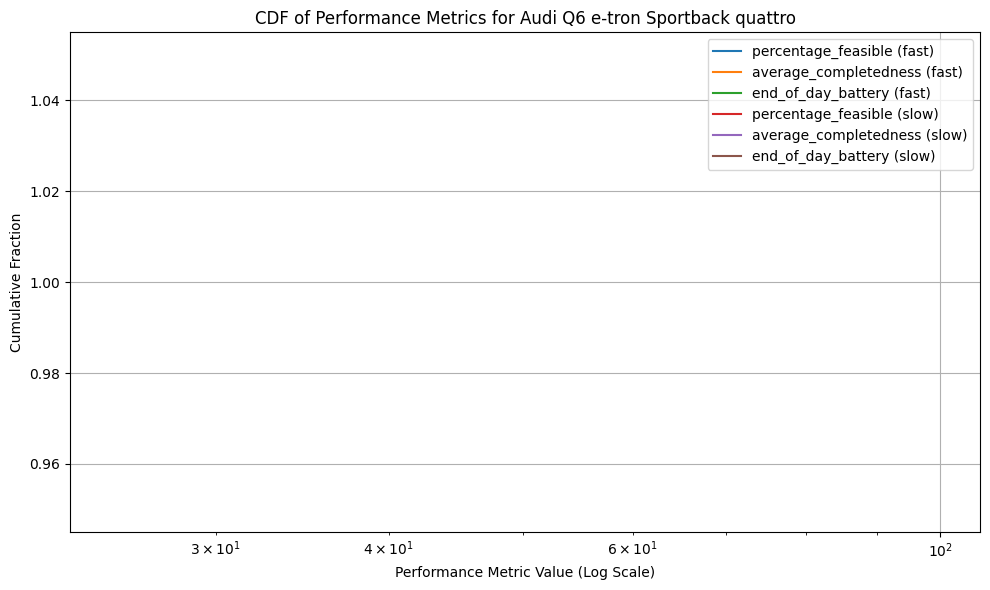

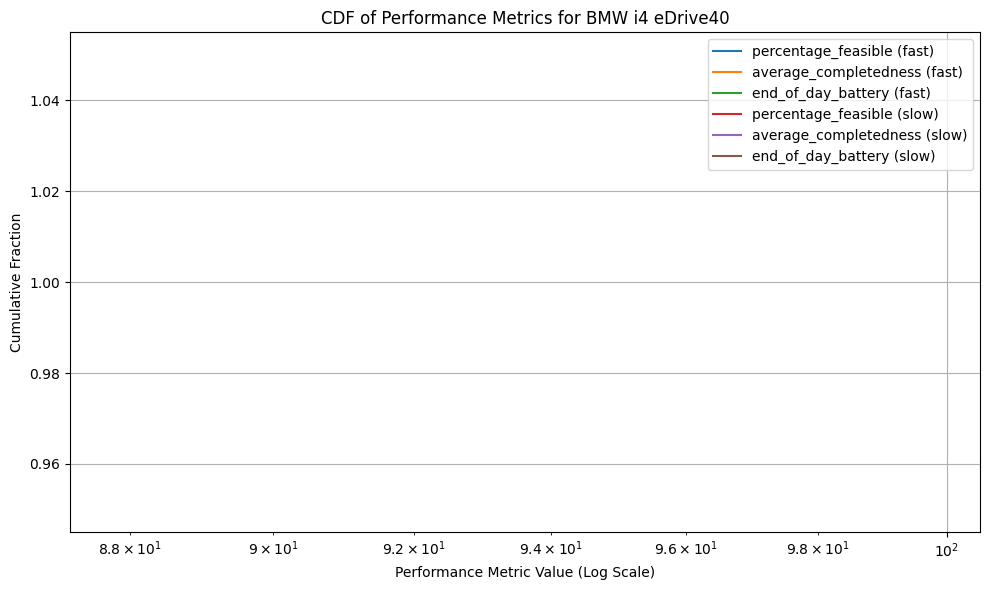

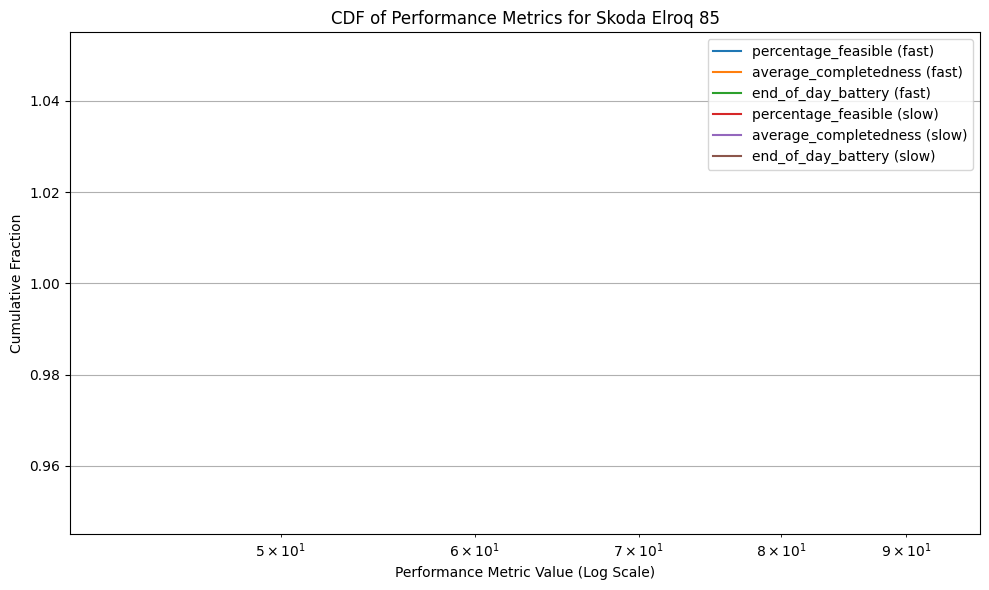

In [100]:
car_models_in_results = final_summary['car_model'].unique()

# Loop through each car model to generate CDF plots
for car_model in car_models_in_results:
    plt.figure(figsize=(10, 6))
    
    # Filter data for the current car model
    car_model_data = final_summary[final_summary['car_model'] == car_model]
    
    for charging_policy in ["fast", "slow"]:
        # Filter data for the current charging policy
        policy_data = car_model_data[car_model_data['charging_policy'] == charging_policy]
        
        # Compute CDF for each performance metric
        for metric in ["percentage_feasible", "average_completedness", "end_of_day_battery"]:
            # Sort the metric values
            sorted_values = policy_data[metric].sort_values()
            
            # Compute the CDF
            cdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
            
            # Plot the CDF
            plt.plot(sorted_values, cdf, label=f"{metric} ({charging_policy})")
    
    # Customize the plot
    plt.xscale("log")
    plt.xlabel("Performance Metric Value (Log Scale)")
    plt.ylabel("Cumulative Fraction")
    plt.title(f"CDF of Performance Metrics for {car_model}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


### 4.c Is there any difference for different EV models? What about their consumption or charging power?

Yes, each EV model has a different capacity and consuptions. Report here the values 

### 4.d If slow AC charging is performed, how the performance change with respect to fast DC charging?

We can see that in general, the slowest speed charging has a large impact in disminishing the overall performances of the EV. Nevertheless, on some car models that may not have the biggest capacity but the lower consuption like the BMW, it seems that the charging mode has litte impact. This could indicate that the road mostly used by potential users of this vehicle could be the best fit for the consuption associated with these roads. 

### 4.e report and comment the difference in performance among the clusters

Cluster performance summary:
   cluster charging_policy  unfeasible_trips  car_model  total_vehicles  \
0        0            fast            410451          3             235   
1        0            slow            410735          3             235   
2        1            fast           1393329          3             262   
3        1            slow           1393329          3             262   
4        2            fast           1398573          3             500   
5        2            slow           1398573          3             500   

   avg_unfeasible_trips_per_vehicle  
0                       1746.600000  
1                       1747.808511  
2                       5318.049618  
3                       5318.049618  
4                       2797.146000  
5                       2797.146000  


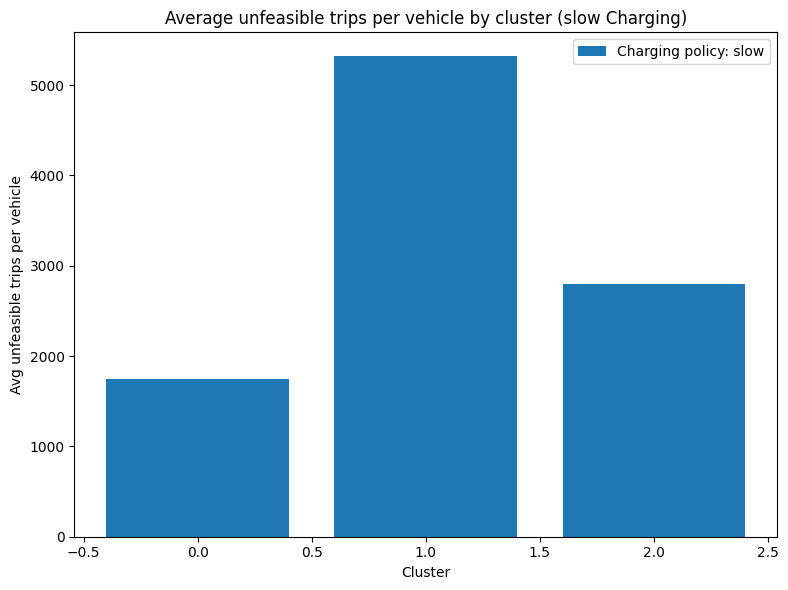

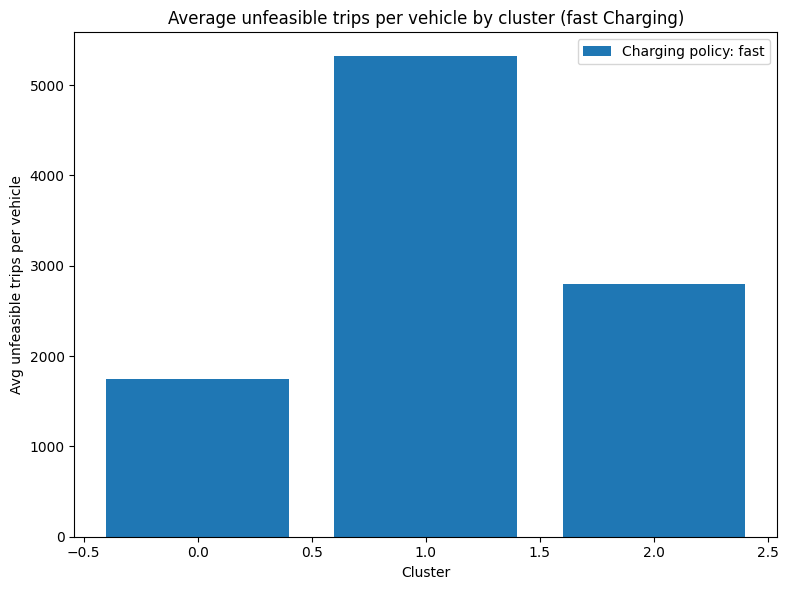

In [ ]:
# Call our previously defined clustering functions
enriched_data = enrich_vehicle_data(df)
clustered_data = perform_clustering(enriched_data, n_clusters=3)

# Merge clustering results with unfeasible trip details
clustered_performance_data = pd.merge(unfeasible_trip_df, clustered_data[['vehicle_id', 'cluster']], on='vehicle_id')

# Aggregate performance metrics by cluster and charging policy
cluster_performance = clustered_performance_data.groupby(['cluster', 'charging_policy'], as_index=False).agg({
    'unfeasible_trips': 'sum',
    'car_model': 'nunique'  # Number of unique car models in each cluster
})

# Calculate average unfeasible trips per vehicle in each cluster
total_vehicles_per_cluster = clustered_performance_data.groupby('cluster')['vehicle_id'].nunique().reset_index()
total_vehicles_per_cluster.rename(columns={'vehicle_id': 'total_vehicles'}, inplace=True)

cluster_performance = pd.merge(cluster_performance, total_vehicles_per_cluster, on='cluster')
cluster_performance['avg_unfeasible_trips_per_vehicle'] = (
    cluster_performance['unfeasible_trips'] / cluster_performance['total_vehicles']
)


# Bar plot for average unfeasible trips per vehicle by cluster
for policy in ['slow', 'fast']:
    plt.figure(figsize=(8, 6))
    subset = cluster_performance[cluster_performance['charging_policy'] == policy]
    plt.bar(subset['cluster'], subset['avg_unfeasible_trips_per_vehicle'], label=f'Charging policy: {policy}')
    plt.title(f'Average unfeasible trips per vehicle by cluster ({policy} Charging)')
    plt.xlabel('Cluster')
    plt.ylabel('Avg unfeasible trips per vehicle')
    plt.legend()
    plt.tight_layout()
    plt.show()

